<font color='salmon' size="4">Predicting churn with ski-learn</font> 

origin :http://blog.yhat.com/posts/predicting-customer-churn-with-sklearn.html

In [184]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 50
sns.set_style("dark")
sns.set_palette("Blues_d")


In [89]:
data=pd.read_csv("churn.csv")

In [431]:
def create_confusion(list_estimator,y,x,figsize=(15,6)):
    
    f=plt.figure(figsize=figsize)
    
    for i,e in enumerate(list_estimator):
        
        ax=f.add_subplot(1,len(list_estimator),i+1)
        
        ax.set_title(e.steps[0][0])
        
        sns.heatmap(confusion_matrix(y,e.predict(x)),annot=True,fmt="d", cmap="Reds",ax=ax)
        
    print("x= Predicted and y=True class")
        


#### Data Transformation

In [90]:
# some columns are not interesting=> Phone is too fuzzy, State contains too many values to be changed in 

data=data.drop(['State','Area Code','Phone'],axis=1)

# columns have to be changed in binary
def col_to_bin (x,values):
    
    if x==values:
        return 1
    else:
        return 0
    
data["VMail Plan"]=data["VMail Plan"].apply(lambda x:col_to_bin(x,"yes"))
data["Int'l Plan"]=data["Int'l Plan"].apply(lambda x:col_to_bin(x,"yes"))
data["Churn?"]=data["Churn?"].apply(lambda x:col_to_bin(x,"True."))

# Create x and y dataset

y=data["Churn?"]
x=data.drop("Churn?",axis=1)

# Normalization of the features

scaler = StandardScaler()
x=scaler.fit_transform(x)

#### Model Selection

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.2s finished


----------------------------------------------------------
Test of the algo : RandomForestClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best F1 score: 0.779 

randomforestclassifier__max_depth: 155
randomforestclassifier__min_samples_split: 3
----------------------------------------------------------
Test of the algo : KNeighborsClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best F1 score: 0.478 

x= Predicted and y=True class


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


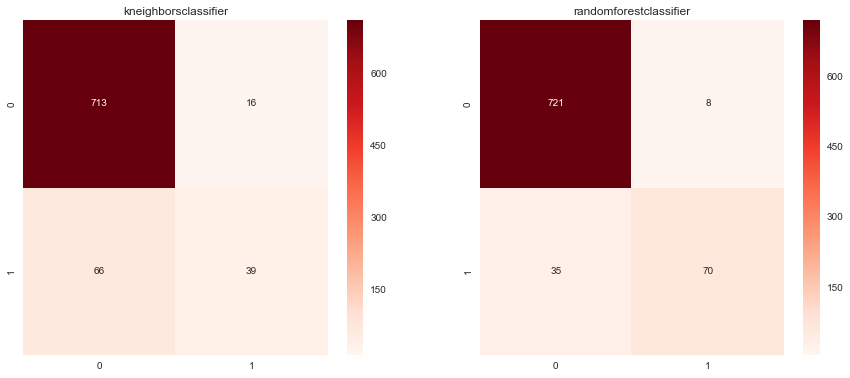

In [432]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

list_result={}

parameters_dt = {'randomforestclassifier__max_depth': (150, 155, 160),
'randomforestclassifier__min_samples_split': (1, 2, 3)}

parameters_knn = {}

Models = {RF(criterion='entropy'):parameters_dt,KNN():parameters_knn}

for m,p in Models.items():
    
    print("----------------------------------------------------------")
    
    print("Test of the algo : %s \n" % str(m)[:str(m).find("(")])
    
    pipeline=make_pipeline(m)
    
    grid_search = GridSearchCV(pipeline, p,cv=5, n_jobs=-1,verbose=5, scoring='f1')
    
    grid_search.fit(x_train,y_train)
    
    print ('\nBest F1 score: %0.3f \n' % grid_search.best_score_)
    
    best_parameters = grid_search.best_estimator_.get_params()
    
    for param_name in sorted(p.keys()):
        
        print ('%s: %s' % (param_name,best_parameters[param_name]))
        
    list_result[grid_search.best_estimator_]=grid_search.best_score_
    
    
create_confusion(list_result,x=x_test,y=y_test)

In [416]:
best_estimator=max(list_result.keys(), key=(lambda k: list_result[k]))

predictions = best_estimator.predict(x_test)
print (classification_report(y_test, predictions))


             precision    recall  f1-score   support

          0       0.93      0.99      0.96       708
          1       0.93      0.60      0.73       126

avg / total       0.93      0.93      0.93       834

